In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sysName = "P1"

## Material parameters and other general definitions

In [2]:
# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha_YIG = 1.75e-4    # Gilbert damping (-)

Ms_YIG = 140.7e3           # Saturation magnetisation (A/m). 

A_YIG = 4.22e-12           # Exchange stiffness (J/m)

## Sample and mesh cell creation

In [3]:
# Geometry [m]
t = 50e-9
w = 500e-9
l = 60e-6

# self absorbing boundary condition
band = 0.25e-6

sourceWidth=40e-9 #cercare bene la misura sul righello
sourcePos=band #almeno iniettiamo le waves nel bulk, possiamo modificare

# Mesh cell [nm]
cx = 12.5e-9
cy = 12.5e-9
cz = t

cell = (cx, cy, cz)

# Zeeman field
Hx = 50 * Oe
Hy = 0
Hz = 0
H_DC = (Hx, Hy, Hz)

# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization

## Energy and boundary conditions definition

In [4]:
# demagnetizing energy
dem = mm.Demag()
# exchange energy
ex = mm.Exchange(A=A_YIG)
# zeeman energy
zem = mm.Zeeman(H=H_DC, name='bias')

mn = oc.MinDriver()           # minimization driver
td = oc.TimeDriver()          # time driver


## System definition

In [5]:
system = mm.System(name=sysName)
region = df.Region(p1=(-l, -w, 0), p2=(l, w, t))
mesh = df.Mesh(region=region, cell=cell)


def alpha_abs(point):
    x, y, z = point
    if (-l/2 < x < -l/2+band):
        return (((x+l/2-band)**2)/(band)**2+alpha_YIG)

    if (l/2-band < x < l/2):
        return (((x-l/2+band)**2)/(band)**2+alpha_YIG)

    else:
        return (alpha_YIG)


alpha = df.Field(mesh, nvdim=1, value=alpha_abs)

## System initialization

In [6]:
# macro to return correct saturation magnetisation inside or outside the sample
def Ms_value(pos):
    # from 0, only inside the sample
    x, y, z = pos

    if (-l/2 < x < l/2 and -w/2 < y < w/2 and 0 < z < t):                                        # rect
        return Ms_YIG

    else:                                                                    # empty space
        return 0


system.m = df.Field(mesh, nvdim=3, value=m0, norm=Ms_value)

## Check system current state

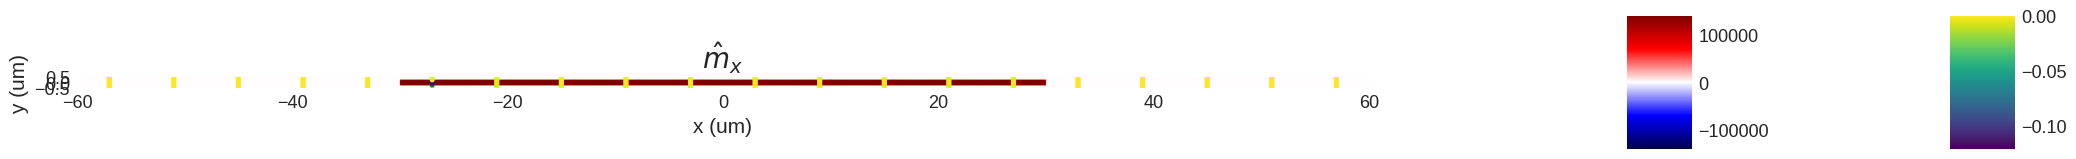

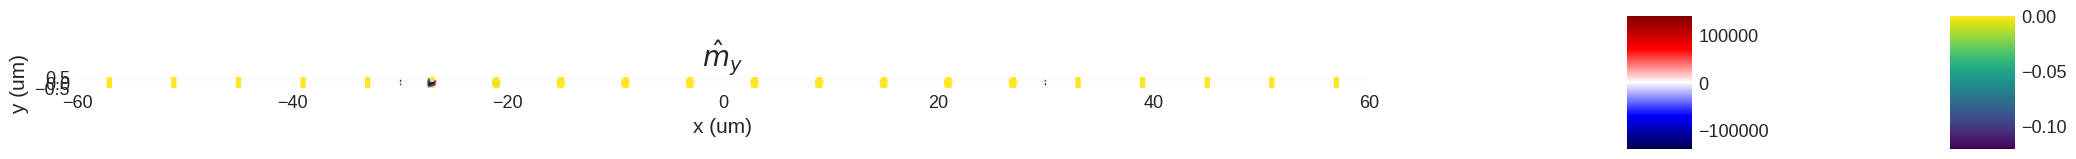

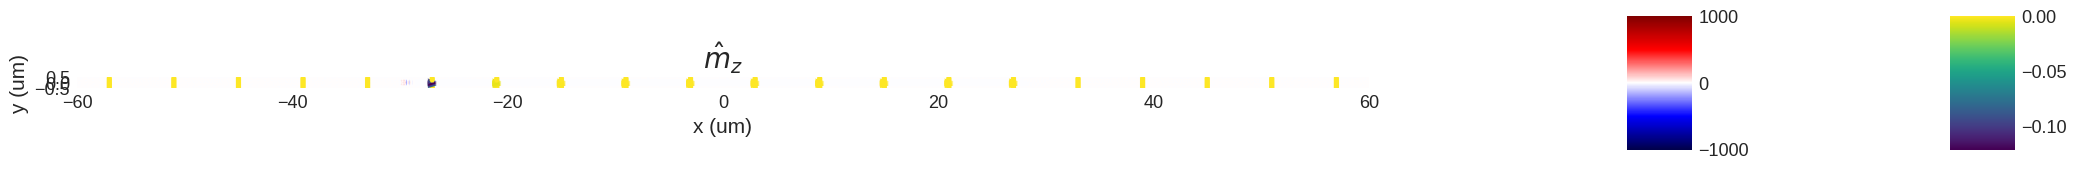

In [19]:
fig,ax =plt.subplots(figsize=(25,10))

plt.title('$\hat m_x$')
"""
    system.m accesses the megnetization
    m.x accesses the x component
    x.sel("z") means "sliced at a fixed value of z", by defaut the middle of the system
    from mpl.scalar on it's just about putting the red/blue color code on the right
    """
system.m.x.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
"""
    this basically just shows the vaues of the vector field m, as colored dots/arrows. 
    Uses the matplotlib.quiver method
    for low fields you only see yellow dots since the equilibrium magnetization is parallel to z
    """
system.m.sel("z").resample((20,10)).mpl.vector(ax=ax, headwidth=3, scale=2e7) 


fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_y$')
system.m.y.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_z$')
system.m.z.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

## Drive to equilibrium state

In [ ]:
# get system to equilibrium
system.energy = dem + ex + zem
mn.drive(system)

damping = mm.Damping(alpha=alpha)
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + damping

Running OOMMF (ExeOOMMFRunner)[2024/01/12 11:58]... (24.2 s)


## RF injection and time simulation settings definition

In [13]:
# inject RF field and time sim
T = 1e-9
f_MAX = 3e9

f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)
t_0 = T/sampling


def Hspace_RF(point):
    x, y, z = point
    if (-l/2+sourcePos< x < -l/2+sourcePos+sourceWidth and -w/2 < y < w/2 and 0 < z < t):
        return (0, 0, 10*Oe)
    else:
        return (0, 0, 0)


H_RF = df.Field(mesh, nvdim=3, value=Hspace_RF)
zemRF = mm.Zeeman(H=H_RF, func='sinc', f=f_MAX, t0=T/sampling, name='RF')
#system.energy = dem + ex+zem
#system.energy += zemRF
td.drive(system, t=T, n=sampling, n_thread=19)

Running OOMMF (ExeOOMMFRunner)[2024/01/12 12:04]... (180.0 s)


In [14]:
data = md.Data(sysName)
array = data[-1].to_xarray()
data = np.array(array)

prende l'ultimo drive, su tutti i sample (:), su tutti i valori di x dove l'assorbimento è basso (lontano dai bordi), su un fissato t e un fissato z. L'ultima cifra nella [] indica la componente x, y o z di m dovrebbero essere numsample*numMesh lungo x

In [15]:
mx = data[:, round((l/2+band)/cx):round((3/2*l-band)/cx), round(w/cy), 0, 0]
my = data[:, round((l/2+band)/cx):round((3/2*l-band)/cx), round(w/cy), 0, 1]
mz = data[:, round((l/2+band)/cx):round((3/2*l-band)/cx), round(w/cy), 0, 2]

In [16]:
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, round(l/cx-2*band/cx)))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1, round(l/cx-2*band/cx)))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, round(l/cx-2*band/cx)))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

Text(0.5, 0, '$kz$ (1/m)')

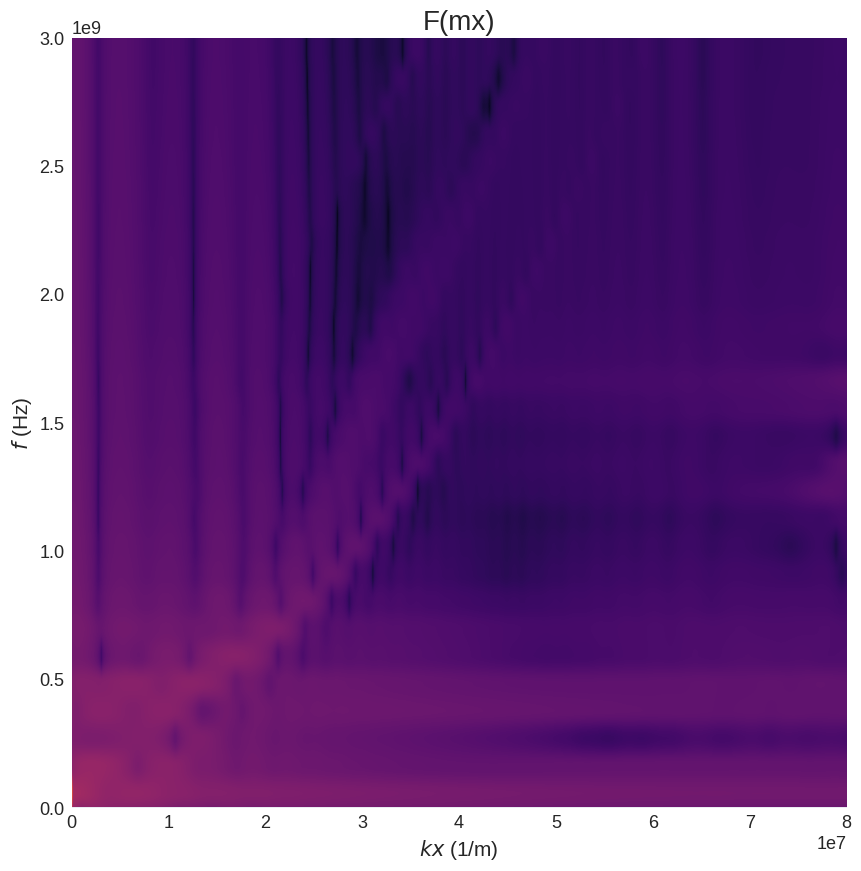

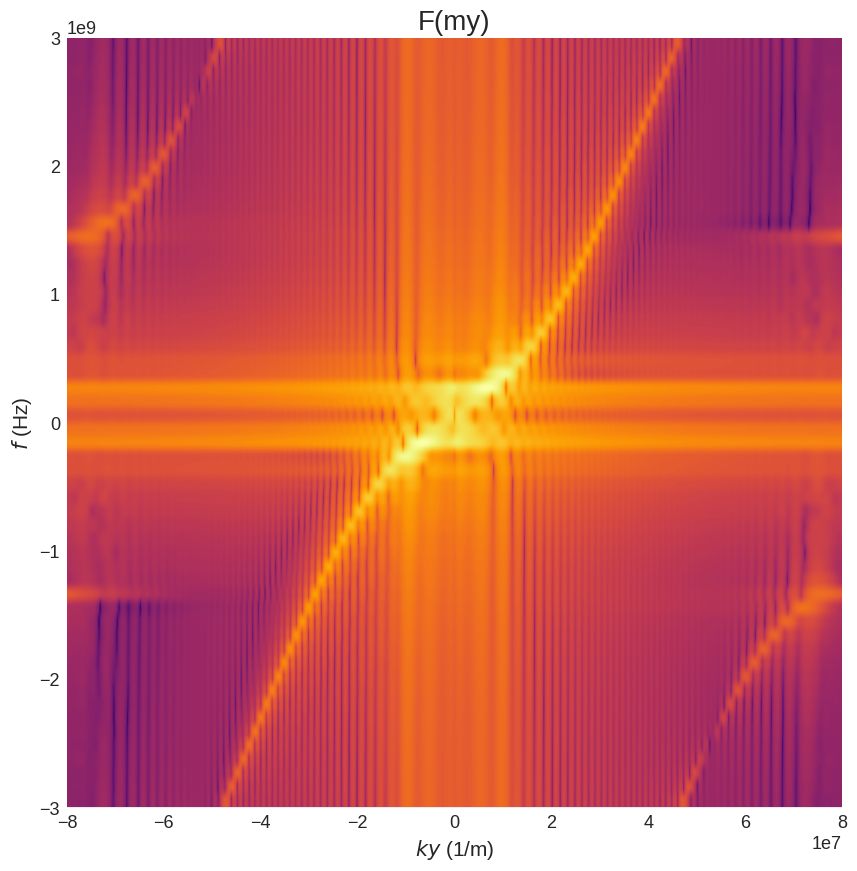

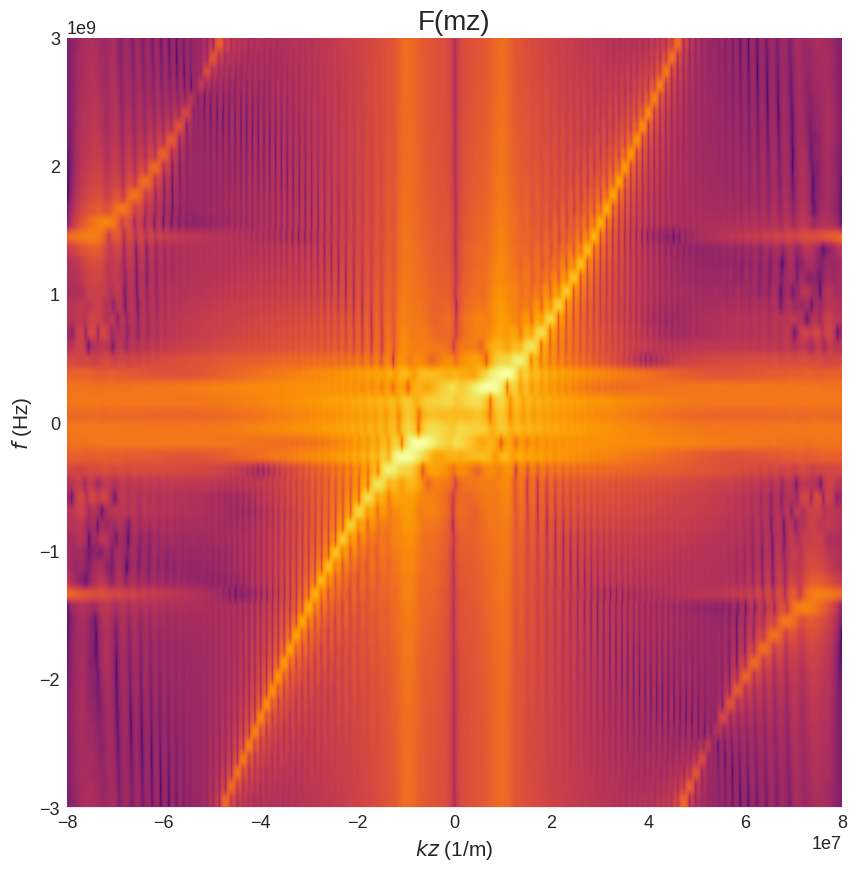

In [17]:
# Show the intensity plot of the 2D FFT
plt.figure(figsize=(10, 10))
plt.title('F(mx)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_x)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")
plt.ylabel("$f$ (Hz)")
plt.xlabel("$kx$ (1/m)")

plt.xlim([0, 1/cx])
plt.ylim([0, f_MAX])

plt.figure(figsize=(10, 10))
plt.title('F(my)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_y)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")

plt.ylabel("$f$ (Hz)")
plt.xlabel("$ky$ (1/m)")


plt.figure(figsize=(10, 10))
plt.title('F(mz)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_z)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")
plt.ylabel("$f$ (Hz)")
plt.xlabel("$kz$ (1/m)")